In [ ]:
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, matthews_corrcoef
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder

In [ ]:
full_wind = pd.read_csv('/content/F_ptmint_prot_wind_enc.csv')

wind_y = full_wind['Effect']
wind_x =  full_wind.drop(columns = ['Effect', 'Unnamed: 0', 'Site', 'Is_int'])
l = range(31)
drop = [f'W_{f}' for f in l]
#wind_x = wind_x.drop(columns = drop)
#wind_x = wind_x.drop(columns = drop2)
print(wind_x.head())

   PTM  prot_1_0  prot_1_1  prot_1_2  prot_1_3  prot_1_4  prot_1_5  prot_1_6  \
0    3  0.017065  0.070142  0.046984  0.046957  0.026163  0.033274 -0.021334   
1    3  0.036717  0.109508  0.068484  0.030021  0.015741  0.043729 -0.016118   
2    3 -0.006256  0.036416  0.046857 -0.003223 -0.024214  0.037480 -0.019146   
3    3 -0.006256  0.036416  0.046857 -0.003223 -0.024214  0.037480 -0.019146   
4    3  0.009785  0.011402  0.031219 -0.000708  0.005161  0.050626 -0.024014   

   prot_1_7  prot_1_8  ...  wind_1014  wind_1015  wind_1016  wind_1017  \
0 -0.062827  0.093360  ...  -0.146909  -0.089104   0.072179   0.074085   
1 -0.058283 -0.034249  ...  -0.044680   0.040204  -0.087387   0.030192   
2 -0.049926 -0.012072  ...   0.030425   0.045601  -0.096821  -0.122525   
3 -0.049926 -0.012072  ...   0.030425   0.045601  -0.096821  -0.122525   
4 -0.036979  0.051468  ...  -0.037784  -0.080585  -0.099626   0.013884   

   wind_1018  wind_1019  wind_1020  wind_1021  wind_1022  wind_1023  
0   

In [ ]:
X_train_wind, X_test_wind, y_train_wind, y_test_wind = train_test_split(wind_x, wind_y, test_size=0.2, random_state=42)

results wind

[8.97023694e-05 6.21547001e-04 3.20929314e-04 ... 6.28368881e-04
 1.68178637e-05 1.33463166e-04]
[1907 1872 1982 ... 2616  796   77]
[1907 1872 1982 2030 2083 1999 2029 1640 1197 2947 1228 2664 2486 1459
 1883 2322 1617  174 1284 3053 1923 1396 1214 1084 1727  341  353 1150
 1569 1723 1052 2038 1608 1750 1315 2793 2081  188 1054   33  503  406
 1096 1810 1381 1528 1825   57 1508  373 1533 1650 1276 1477   20 1176
 1881 1057  466 1886 1217 1174 1639 1839 1800 2931 1298 1726  830 2841
 1912  562 1059  670 1470 1301  292 2016 1009  816 1990 1365 1374 1199
 1976  274 1139  509  444 2305   71 1926 1035 1625 1738 1899   51  335
 1118  438 1406 1507 1981 1725 1575 1132 1690 2645 2581 1345 1355 1491
 1069 1786 1555  259 2019  490 1097 1857  375 1624    5 2022 1559 1328
  170 1790 1397 1062 2000 1108 1984 2945 1903 1742 1496 1264 2238 1405
 1344  629  257 1195 2195 1945 2613 2015 2762  552  616 2037  990 1454
 1927 1148 1734 2162 1664 1294 1645  948 1280 1972 1203 1878 1512 1075
 2021 1306  253

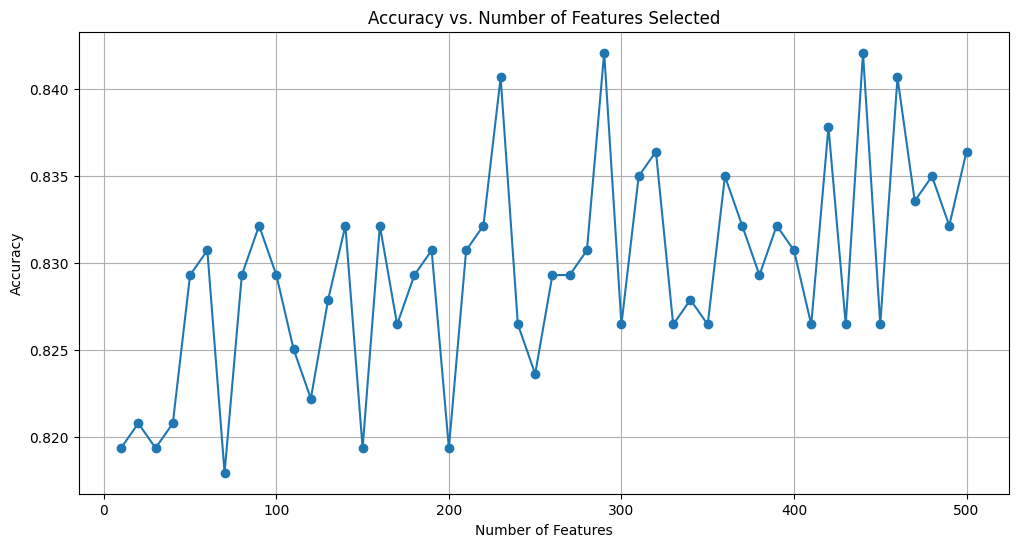

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Step 1: Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=10)
clf.fit(X_train_wind, y_train_wind)

# Step 2: Get and sort the feature importances
importances = clf.feature_importances_
print(importances)
indices = np.argsort(importances)[::-1]

print(indices)
# Step 3: Select a number of top features to keep
# For example, keep the top 500 features
num_top_features = 500
top_features = indices[:num_top_features]
print(top_features)
# Reduce X to the top features
X_train_reduced = X_train_wind.iloc[:,top_features]
X_test_reduced = X_test_wind.iloc[:, top_features]


# Initialize the classifier for RFE
rfe_clf = RandomForestClassifier(n_estimators = 100, random_state=10)

# Lists to store the results
num_features_list = []
accuracy_list = []
features = []
# We will vary the number of features in steps of 10 for RFE
step = 10
feature_range = range(step, num_top_features + 1, step)

# Loop over the range of number of features to perform RFE and record accuracy
for n_features in feature_range:
    rfe = RFE(estimator=rfe_clf, n_features_to_select=n_features, step = 10)
    rfe = rfe.fit(X_train_reduced, y_train_wind)
    accuracy = rfe.score(X_test_reduced, y_test_wind)
    num_features_list.append(n_features)
    accuracy_list.append(accuracy)
    features.append(rfe.get_feature_names_out())
    print(f"Features: {n_features}, Accuracy: {accuracy:.4f}")

# Plot the accuracy for each feature count
plt.figure(figsize=(12, 6))
plt.plot(num_features_list, accuracy_list, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Features Selected')
plt.grid(True)
plt.show()




In [ ]:
feature = features[8]
print(feature)

['prot_2_882' 'prot_2_847' 'prot_2_957' 'prot_2_1005' 'wind_34'
 'prot_2_172' 'wind_898' 'prot_2_203' 'wind_615' 'wind_437' 'prot_2_434'
 'prot_2_858' 'wind_273' 'prot_2_592' 'prot_1_173' 'prot_2_59'
 'prot_1_340' 'prot_1_352' 'prot_2_698' 'prot_2_1013' 'prot_2_583'
 'prot_1_32' 'prot_1_405' 'prot_1_56' 'prot_2_483' 'prot_2_861'
 'prot_2_614' 'prot_2_814' 'wind_882' 'prot_2_273' 'prot_1_829' 'wind_792'
 'prot_1_561' 'prot_1_291' 'prot_1_815' 'prot_2_965' 'prot_2_951'
 'prot_1_273' 'prot_2_114' 'prot_2_901' 'prot_1_437' 'prot_2_107'
 'wind_596' 'wind_532' 'prot_2_44' 'prot_1_374' 'prot_2_372' 'prot_2_471'
 'prot_2_319' 'wind_564' 'prot_1_615' 'prot_2_996' 'prot_1_814' 'wind_961'
 'wind_613' 'prot_2_573' 'wind_978' 'prot_2_193' 'prot_1_651' 'prot_1_547'
 'prot_1_501' 'prot_2_803' 'wind_495' 'wind_55' 'wind_659' 'prot_1_466'
 'prot_2_6' 'wind_420' 'wind_836' 'wind_865' 'wind_703' 'wind_850'
 'wind_922' 'prot_1_453' 'wind_878' 'prot_2_876' 'prot_1_887' 'wind_580'
 'wind_793' 'prot_1_253' '